# 使用DMT训练框架

通过以下4步，使用DMT框架训练并使用你自己的深度学习模型：
1. 定义数据集
2. 定义模型
3. 重写训练器和测试方法
4. 编写配置文件

## 1. 定义数据集

DMT 框架使用 `torch.utils.data.Dataset` 作为数据集的基类，唯一的限制是你只能通过传入一个 `EasyDict` 实例 `args` 参数来实例化数据集。

例如在 `src_classify` 中，我们使用一个封装好的 MNIST 数据集，它带有两个自定义方法 `transforms` 和 `inv_transforms` 对数据进行归一化和逆归一化。

Text(0.5, 1.0, 'Label: 8')

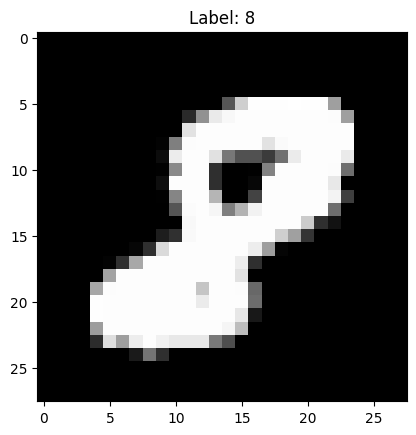

In [13]:
from easydict import EasyDict
from src_classify.datasets import MNIST

args_data = EasyDict(dict(root = "data", train = True))
ds = MNIST(args_data)

import random
index = random.randint(0, len(ds))
img, label = ds.inv_transforms()(ds[index][0]), ds[index][1]

import matplotlib.pyplot as plt
plt.imshow(img.squeeze(), cmap = "gray")
plt.title(f"Label: {label}")


## 2. 定义模型

DMT 框架使用 `torch.nn.Module` 作为模型的基类，同样的，你只能通过传入一个 `EasyDict` 实例 `args` 参数来实例化模型。

例如在 `src_classify` 中，我们使用一个封装好的 ResNet 模型。它带有两个自定义方法 `compute_loss` 和 `predict` 分别用来在训练阶段计算损失函数和在测试阶段进行预测。

In [ ]:
from src_classify.models import ResnetModel

args_model = EasyDict(dict(
    input=1, output=10, hidden_dims=[32, 64, 128]
))
model = ResnetModel(args_model)

## 3. 重写训练器和测试方法

DMT框架使用自定义的 `Trainer` 作为训练器的基类，你需要继承它编写自己的训练器，并重写以下方法：

训练模型：
- 必须重写的方法：
  - `_compute_loss`：计算损失函数，返回两个字典分别记录损失函数的值和相应的权值超参数
- 按需求重写的方法：
  - `_eval_epoch`：在训练过程中计算测试指标的方法
  - `_sample_epoch`：在训练过程中生成新样本的方法

测试模型：
- 必须重写的方法：
  - `eval`: 在测试模式下需要重写，用来计算测试集上的指标
  - `sample`：在采样模式下需要重写，用来生成新样本

例如在 `src_classify` 中，我们使用 `ClassifyTrainer` 作为训练器。

## 4. 编写配置文件

DMT框架使用 *.yml* 文件对实验进行配置，配置文件分为7个部分：
1. 实验信息：包括名称、os、gpu等信息
2. 模型参数
3. 数据集参数
4. 训练过程参数：包括优化器、学习率、训练轮数等
5. 评估过程参数：包括评估批大小等
6. 采样过程参数
7. 其他参数

具体可参考`base_config.yml`文件。

# 例子：使用ResNet对MNIST数据集进行手写数字分类

代码目录：`./src_classify`

- 工作目录: 
    ```bash
    $ pwd
    ~/deep-model-trainer
    ```
- 训练模型
    ```bash
    $ python src_classify/main.py --config resnet --train
    ```
- 断点继续训练
    ```bash
    $ python src_classify/main.py --config resnet --new_config resume --train 
    ```
- tensorboard monitor
    ```bash
    $ tensorboard --logdir experiments/MNIST-Classification/logs
    ```

# 例子：使用VQ-VAE对MNIST数据集进行手写数字生成

代码目录：`./src_generate`

- 工作目录: 
    ```bash
    $ pwd
    ~/deep-model-trainer
    ```
- 训练VQVAE模型
    ```bash
    $ python src_generate/main.py --config vqvae --train
    ```
- 训练GPTPrior模型 *需要10G显存*
    ```bash
    $ python src_generate/main.py --config prior --train 
    ```
- 从训练好的模型中采样
    ```bash
    $ python src_generate/main.py --config prior --new_config sample --eval
    ```
- tensorboard monitor
    ```bash
    $ tensorboard --logdir experiments/MNIST-Generate/logs

multi-gpu evaluate

In [ ]:
!CUDA_VISIBLE_DEVICES="0,1" accelerate launch --num_processes=2 src_example/main.py --config example --eval

sample

In [ ]:
!CUDA_VISIBLE_DEVICES="0,1" accelerate launch --num_processes=2 src_example/main.py --config example --sample

Tensorboard 可视化训练过程

In [ ]:
!tensorboard --logdir experiments/MLP-ExampleDataset/logs --port=8008